<a href="https://colab.research.google.com/github/CristianMorasso/statistical_project/blob/master/Copia_di_statiscal_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning Project: ALFA Dataset Anaysis


In [1]:
# Download the dataset from our git repository hosted on Github
!pip install icecream sktime scikit-learn polars numpy
!rm -rf statiscal_project
!git clone https://github.com/CristianMorasso/statistical_project.git

LEN_DATASET = 45

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 11.8 MB/s eta 0:00:00
Cloning into 'statistical_project'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 106 (delta 11), reused 3 (delta 1), pack-reused 70
Receiving objects: 100% (106/106), 90.67 MiB | 9.57 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (64/64), done.


# INTRO
## Scopo / Motivazioni
## Outline


# DATASET
[Img UAV]()

The Dataset concerns several fault types in control surfaces of a fixed-wing Unmanned Aerial Vehicle (UAV) for use in Fault Detection and Isolation.

The data is collected using sensors, like GPS or wind estimation, local and global state (internal state of UAV).

The failures can be:
* Engine
* Aileron (can be used as specific or generic)
* Ruddler (can be used as specific or generic)
* Elevator (can be used as specific or generic)

[Img Traiettoria/esempio dati]()

*Mettere hist con distribuzioni classi*


In [2]:
# Read the data from the csv files
import numpy as np
import pandas  as pd
import os
from random import shuffle

dataset_dir = "statistical_project/data"
dfs = [] # dataframe list

classToString= {0:"no_failure", 1:"elevator", 2:"engine", 3:"rudder",4:"ailerons"}

stringToClass = {}
for key, value in classToString.items():
  stringToClass[value] = key

series_counter = 0

for _, cl  in enumerate(os.listdir(dataset_dir)):
  path1 = os.path.join(dataset_dir, cl)

  # Get rid of files or bad dirs
  if not os.path.isdir(path1) or cl == "features":
    print(f"{cl} is not a dir or not useful!")
    continue

  for f in  os.listdir(path1):
    pathf = os.path.join(path1, f)
    df = pd.read_csv(pathf)

    # Fix the label field
    try:
      df["field.data"] = df["field.data"].apply(func=lambda x: stringToClass[cl] if int(x)>0 else 0)
      df = df.rename(columns={"field.data": "Y"})
    except:
      print(f"Error for {cl}")
      df["Y"]  = pd.Series([ 0 for _ in range(df.shape[0])])

    # Drop the time column!
    df = df.drop("%time", axis=1)

    # Save it
    dfs.append(df)
    series_counter+=1

print(f"\nNumber of Time Series: {len(dfs)}")
assert len(dfs) == LEN_DATASET # We know the exact number from the repo

# Shuffle the array of dataframes for so that classes are not contiguous
shuffle(dfs)

features is not a dir or not useful!
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
Error for no_failure
README.md is not a dir or not useful!
__init__.py is not a dir or not useful!

Number of Time Series: 45


## Preprocessing
### Outline
* Removing not complitly shared features 
* Imputing of missing values
* Feature selection: SimpleKBest (from [SK-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)) and RandomForest
* Splitting in Windows

### Remove not usable features

In [3]:
from sklearn.impute import SimpleImputer
import numpy as np

# Remove useless features and inpute missing values
#
# finally use the mask on every timeseries of the OG dataframes list

# Remove all the features that are not shared by all Time Series
#
# Only use the variables that can be found in all the dataframes
features = []
# Get the biggest set:
# (We are considering that that the bigger set is just a superset and has all the other base features)
for df in dfs:
   features = max(features, df.columns.values, key=lambda x: len(x))
# Then get the set intersection of all of the features sets
features = set(features)
for df in dfs:
  features = features.intersection(set(df.columns.values))

# Apply the feature mask
print(len(features))
dfs = list(map(lambda x: x[list(features)] , dfs))

# Concat all the time series in as single dataframe for later :)
concatted_dfs = pd.concat(dfs)
concatted_y = concatted_dfs["Y"]
concatted_dfs = concatted_dfs.drop("Y", axis=1)

26


In [4]:
from sklearn.impute import SimpleImputer
import numpy as np

# Inpute the missing values first
dfs = list(map(lambda x: SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(x) , dfs))

### Feature Selection

##### With SelectKBest
(Link [Here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html))

Descrizione 

In [5]:
# Print the number of nans per per each columns
print(concatted_dfs.isnull().sum())
print(f"Length of Concatted Dataframes: {len(concatted_dfs)}")

delta_y                         59
field.twist.angular.x          143
delta_roll_airspeed             60
delta_yaw                       57
field.angular_velocity.x       291
delta_pitch                     57
field.xtrack_error              57
field.linear_acceleration.y    291
field.aspd_error                57
field.twist.linear.x           143
field.linear_acceleration.x    291
delta_x                         59
field.twist.linear.y           143
field.twist.angular.y          143
field.orientation.x            291
delta_z                         59
field.twist.angular.z          143
field.orientation.y            291
field.orientation.z            291
field.linear_acceleration.z    291
field.alt_error                 57
field.angular_velocity.y       291
delta_roll                      59
field.angular_velocity.z       291
field.twist.linear.z           143
dtype: int64
Length of Concatted Dataframes: 93670


In [6]:
from sklearn.feature_selection import SelectKBest
import numpy as np

# Inpute the nan values to the mean of the other entries value of the same column
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(concatted_dfs)
inp_out = imp.transform(concatted_dfs)

# Get the best 20 features of the dataset
columns_ = concatted_dfs.columns.values
feature_mask= SelectKBest(k=20).fit(inp_out, concatted_y).get_feature_names_out(columns_)

# ( Uses sklearn.feature_selection.f_classify )
print("Feature Mask:")
print(feature_mask)
print(f"Length of Feature Mask: {len(feature_mask)}")

Feature Mask:
['delta_y' 'delta_roll_airspeed' 'delta_yaw' 'delta_pitch'
 'field.xtrack_error' 'field.linear_acceleration.y' 'field.aspd_error'
 'field.twist.linear.x' 'field.linear_acceleration.x'
 'field.twist.linear.y' 'field.orientation.x' 'delta_z'
 'field.twist.angular.z' 'field.orientation.y' 'field.orientation.z'
 'field.linear_acceleration.z' 'field.alt_error' 'delta_roll'
 'field.angular_velocity.z' 'field.twist.linear.z']
Length of Feature Mask: 20


#### With randomForest scores:
Descrizione

In [7]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

def plot_feature_importances(model):
    fig_scale = 0.9
    n_features = len(concatted_dfs.columns) # take the features names from the Concatted DataFrame
    plt.figure(figsize=(7*fig_scale,5.4*fig_scale))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), concatted_dfs.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

Valutare se proporre entrambe le opzioni o solo una

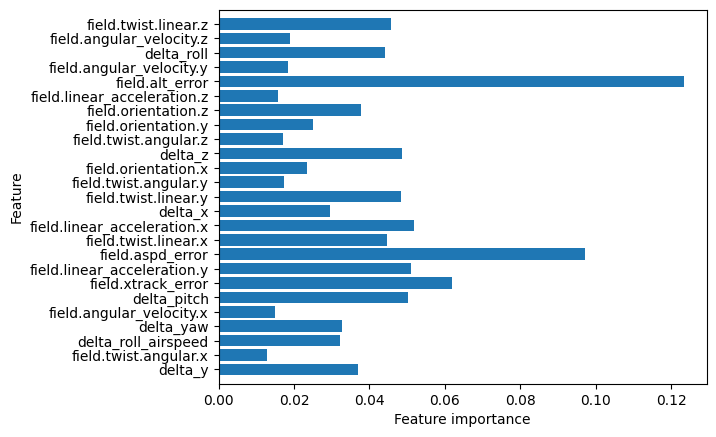

In [8]:
# WITH ERROR COLUMNS:
#
concatted_ndarray = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(concatted_dfs)
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)

# Select the n best features
n = 20
feature_mask = list(zip(concatted_dfs.columns, rf.feature_importances_))
feature_mask.sort(key=lambda x: x[1])
feature_mask = list(map(lambda x: x[0], feature_mask[:n]))

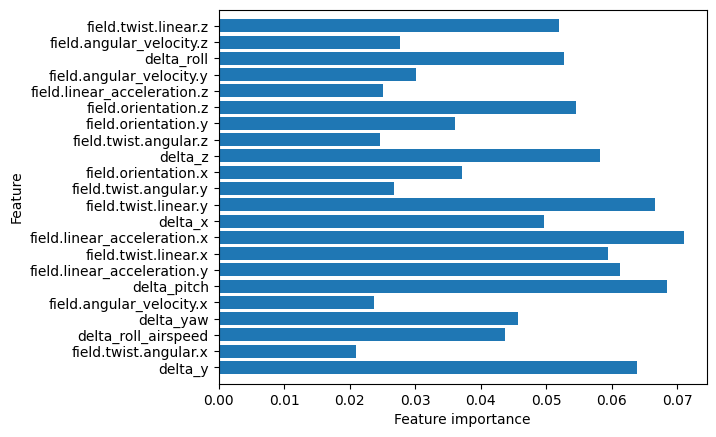

In [9]:
# WITHOUT ERROR COLUMNS:
#
concatted_dfs = concatted_dfs.drop(["field.alt_error", "field.xtrack_error", "field.aspd_error"], axis=1)
concatted_ndarray = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(concatted_dfs)
rf = RandomForestClassifier()
rf.fit(concatted_ndarray, concatted_y)
# Plot the feature importances
plot_feature_importances(rf)
# Select the n best features
n = 20 # Removing 7 (the ones that are clearly not performing (sub 0.03))
feature_mask = list(zip(concatted_dfs.columns, rf.feature_importances_))
feature_mask.sort(key=lambda x: x[1])
feature_mask = list(map(lambda x: x[0], feature_mask[:n]))

### Split the dataset into windows

We decided to split the time series in windows with size `window_length`, to increase the number of samples but mainly to produce online methods, widely used in Time series analysis. 

In [10]:
from sktime.split import SlidingWindowSplitter

splitted_ndarrays, window_length, step_length = [], 10, 10
splitter = SlidingWindowSplitter(window_length=window_length, step_length=step_length)
splitted_ndarrays = [ list(map(lambda x: x[0], splitter.split_series(df))) for df in dfs] # We are ignoring the forecasting horizon

print(f"Length of windowed dataset: {len(splitted_ndarrays)}")
assert len(splitted_ndarrays) == LEN_DATASET

Length of windowed dataset: 45


In [11]:
# Split into windows
_splitted_ndarrays = []
_splitted_ys = []
features = list(features)
y_index = features.index("Y") # Index of the Y column
features.pop(y_index)
#features = ["flight", "step", *features]

i = 0 # Number of windows

for sa in splitted_ndarrays:
  for a in sa:

    # Retrieve the label and save it separately
    _splitted_ys.append(np.max(a[:,y_index]))
    # And then delete it
    a = np.delete(a, y_index, axis=1)

    # np.concatenate([flight, step, a], axis=1)
    _splitted_ndarrays.append(a)
    i+=1 # Increase window counter

assert len(_splitted_ys) == len(_splitted_ndarrays)
print("n_windows",len(_splitted_ndarrays))

n_windows 9342


### Split in Train and set:

In [12]:
import math
from random import shuffle

train_size = int(math.floor(len(_splitted_ndarrays)*0.8))
zipped = list(zip(_splitted_ndarrays, _splitted_ys))
shuffle(zipped)

X_train, X_test = list(map(lambda x: x[0], zipped[:train_size])), list(map(lambda x: x[0], zipped[train_size:]))
y_train, y_test = np.array(list(map(lambda x: x[1], zipped[:train_size]))), np.array(list(map(lambda x: x[1], zipped[train_size:])))

### Multi-Indexed Pandas Dataframe (sktime Panel)

In [13]:
# Finally let's create a multiIndexed pandas.Dataframe so that we can use our data with the sktime library
def toMultiIndexed(windows, feature_mask):
  _dfs = []
  for i, npVals in enumerate(windows):
    d = pd.DataFrame(npVals,columns=feature_mask)
    # The two columns for the multi-indexed Dataframe
    d.insert(0, "flight", [i for _ in range(int(npVals.shape[0]))], True)
    d.insert(1, "step", pd.RangeIndex(int(npVals.shape[0])), True)
    _dfs.append(d)

  _dfs = pd.concat(_dfs)
  # Set the 2 Indexes (onl  y flight is unique)
  _dfs = _dfs.drop_duplicates(subset=['flight', 'step'], keep='last')
  _dfs = _dfs.set_index(["flight", "step"])

  return _dfs

X_train, X_test = toMultiIndexed(X_train, features), toMultiIndexed(X_test, features)

In [14]:
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")
X_train.head(20)

X_train: (74730, 25)
X_test: (18690, 25)
y_train: (7473,)
y_test: (1869,)


delta_y  field.twist.angular.x  delta_roll_airspeed  delta_yaw  \
flight step                                                                    
0      0     1.231537               0.187818            16.000000   3.676338   
       1     1.225451               0.187818            16.000000   3.676338   
       2     1.222552               0.187818            16.000000   3.676338   
       3     1.213519               0.187818            16.000000   3.676338   
       4     1.204550               0.187818            16.000000   3.676338   
       5     1.204550               0.187818            16.000000   3.676338   
       6     1.173944               0.187818            16.000000   3.676338   
       7     1.173944               0.187818            16.000000   3.676338   
       8     1.137299               0.187818            16.000000   4.929367   
       9     1.125742               0.187818            16.000000   4.929367   
1      0    -8.250038               0.276866             0.134974  30.849609   
       1    -7.846169               0.276866            -0.077114  32.849609   
       2    -7.646558               0.276866            -0.077114  32.849609   
       3    -7.646558               0.276866            -0.077114  32.849609   
       4    -7.264369               0.276866            -0.238262  33.849609   
       5    -8.339523               0.276866            -0.392843  33.655060   
       6    -8.036213               0.276866            -0.392843  33.655060   
       7    -7.840780               0.257440            -0.541201  34.655060   
       8    -7.840780               0.257440            -0.541201  34.655060   
       9    -7.457858               0.257440            -0.541201  34.655060   

             field.angular_velocity.x  delta_pitch  field.xtrack_error  \
flight step                                                              
0      0                     0.187818    -1.212821            3.439752   
       1                     0.187818    -1.362821            3.473148   
       2                     0.187818    -1.502821            3.517675   
       3                     0.187818    -1.502821            3.517675   
       4                     0.187818    -1.602821            3.551071   
       5                     0.187818    -1.602821            3.551071   
       6                     0.187818    -1.642821            3.595599   
       7                     0.102049    -1.642821            3.595599   
       8                     0.102049    -0.515491            3.628994   
       9                     0.102049    -0.515491            3.628994   
1      0                     0.276866     0.463187           -6.938116   
       1                     0.276866     0.983187           -6.706075   
       2                     0.276866     0.993187           -6.706075   
       3                     0.276866     0.993187           -6.706075   
       4                     0.257440     1.523187           -5.696832   
       5                     0.257440     2.451419           -7.863486   
       6                     0.257440     2.461419           -7.863486   
       7                     0.257440     2.461419           -6.725926   
       8                     0.257440     3.791419           -6.725926   
       9                     0.257440     3.791419           -6.725926   

             field.linear_acceleration.y  field.aspd_error  \
flight step                                                  
0      0                        0.735499        424.569794   
       1                        0.735499        424.569794   
       2                        0.735499        419.813538   
       3                        0.735499        419.813538   
       4                        0.735499        419.813538   
       5                        0.735499        419.813538   
       6                        0.735499        413.765625   
       7                        0.500139        413.765625   
    

# Testing Models:

In [15]:
# List all classifiers in sktime
from sktime.registry import all_estimators
all_estimators("classifier", as_dataframe=True) # , filter_tags={"capability:unequal_length":TrueNN

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

,name,object
0,Arsenal,<class 'sktime.classification.kernel_based._ar...
1,BOSSEnsemble,<class 'sktime.classification.dictionary_based...
2,BOSSVSClassifierPyts,<class 'sktime.classification.dictionary_based...
3,BaggingClassifier,<class 'sktime.classification.ensemble._baggin...
4,CNNClassifier,<class 'sktime.classification.deep_learning.cn...
5,CNTCClassifier,<class 'sktime.classification.deep_learning.cn...
6,CanonicalIntervalForest,<class 'sktime.classification.interval_based._...
7,Catch22Classifier,<class 'sktime.classification.feature_based._c...
8,ClassifierPipeline,<class 'sktime.classification.compose._pipelin...
9,ColumnEnsembleClassifier,<class 'sktime.classification.compose._column_...


In [16]:
from sktime.datatypes import MTYPE_REGISTER
pd.DataFrame(MTYPE_REGISTER)

,0,1,2
0,pd.Series,Series,pd.Series representation of a univariate series
1,pd.DataFrame,Series,pd.DataFrame representation of a uni- or multi...
2,np.ndarray,Series,"2D numpy.ndarray with rows=samples, cols=varia..."
3,xr.DataArray,Series,xr.DataArray representation of a uni- or multi...
4,dask_series,Series,xdas representation of a uni- or multivariate ...
5,nested_univ,Panel,"pd.DataFrame with one column per variable, pd...."
6,numpy3D,Panel,"3D np.array of format (n_instances, n_columns,..."
7,numpyflat,Panel,"WARNING: only for internal use, not a fully su..."
8,pd-multiindex,Panel,"pd.DataFrame with multi-index (instances, time..."
9,pd-wide,Panel,"pd.DataFrame in wide format, cols = (instance*..."


# Models, Training and Performance

We choose to use three models (KNN, CNN, RNN), using the same pipeline, then we are showing the results with some metrics.




## Convolutional Neural Network (CNN)
cosa vogliamo scrivere qui?

In [29]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.feature_based import RandomIntervalClassifier
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.datatypes import check_raise
from sklearn.model_selection import LearningCurveDisplay
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sktime.transformations.panel.padder import PaddingTransformer
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.transformations.panel.interpolate import TSInterpolator

print("CONVOLUTIONAL NEURAL NETWORK")
cnn = CNNClassifier(n_epochs=50, batch_size=4, kernel_size=3, avg_pool_size=1, n_conv_layers=3, loss='binary_crossentropy')
check_raise(X_train, mtype="pd-multiindex")
check_raise(y_train, mtype='np.ndarray')
cnn.fit(X_train, y_train)

y_pred_cnn = cnn.predict(X_test)



#clf = Pipeline([
#    ("transform", TSInterpolator(50)),
#     ("concatenate", ColumnConcatenator()),
#     ("classify", TimeSeriesForestClassifier(n_estimators=100)),
#    ("transform", PaddingTransformer()),
#    ("classify", RandomIntervalClassifier(n_intervals=10)),
#])
#clf.fit(X_train, y_train)
#clf.score(X_test,y_test)

CONVOLUTIONAL NEURAL NETWORK
468/468 [==============================] - 1s 2ms/step


### Performances

Accuracy: 0.82

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.98      0.90      1549
         1.0       0.00      0.00      0.00         9
         2.0       0.37      0.17      0.23       135
         3.0       0.00      0.00      0.00        11
         4.0       0.00      0.00      0.00       165

    accuracy                           0.82      1869
   macro avg       0.24      0.23      0.23      1869
weighted avg       0.72      0.82      0.76      1869



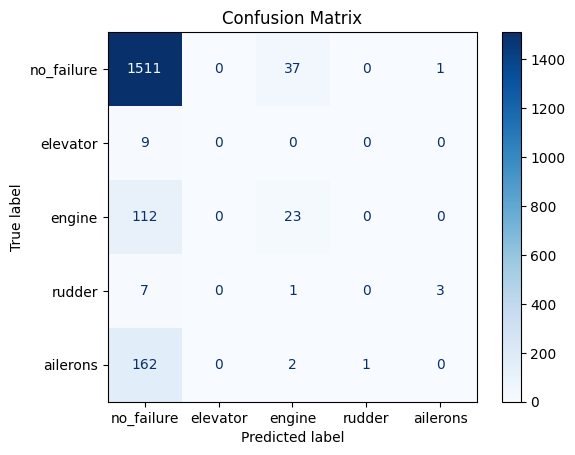

In [30]:
class_labels = np.array(list(classToString.values()))

cnn_acc = accuracy_score(y_test, y_pred_cnn)
print(f"Accuracy: {cnn_acc:.2f}")

report = classification_report(y_test, y_pred_cnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels) #np.unique(y_test)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

RECURRENT NEURAL NETWORK
94/94 [==============================] - 0s 2ms/step
Accuracy: 0.87

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.99      0.93      1549
         1.0       1.00      0.11      0.20         9
         2.0       0.83      0.67      0.74       135
         3.0       1.00      0.73      0.84        11
         4.0       0.00      0.00      0.00       165

    accuracy                           0.87      1869
   macro avg       0.74      0.50      0.54      1869
weighted avg       0.80      0.87      0.83      1869



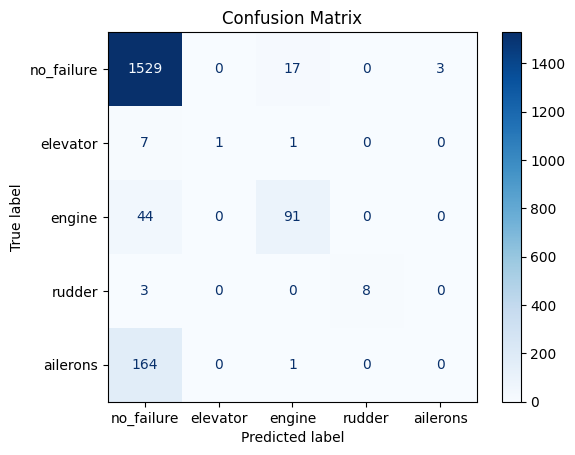

In [31]:
from sktime.classification.deep_learning.rnn import SimpleRNNClassifier

print("RECURRENT NEURAL NETWORK")
rnn = SimpleRNNClassifier(n_epochs=50, batch_size=20, loss='binary_crossentropy')
rnn.fit(X_train, y_train)
# rnn.score(X_test, y_test)

y_pred_rnn = rnn.predict(X_test)

rnn_acc = accuracy_score(y_test, y_pred_rnn)
print(f"Accuracy: {rnn_acc:.2f}")

report = classification_report(y_test, y_pred_rnn, zero_division = 0.0)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_rnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


K-NEIGHBORS


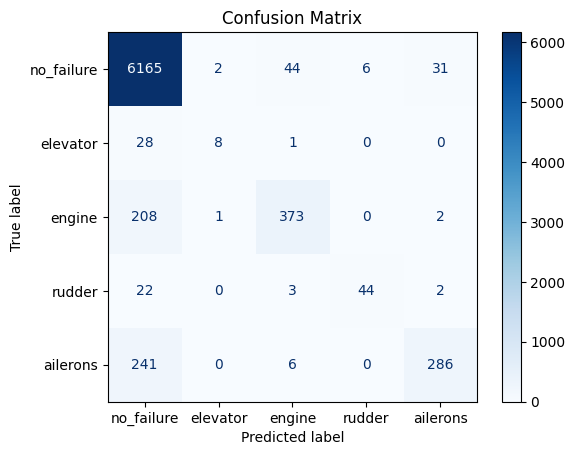

In [32]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

print("K-NEIGHBORS")
knn = KNeighborsTimeSeriesClassifier(n_neighbors=5, distance='dtw')
knn.fit(X_train, y_train)

y_pred_knn_train = knn.predict(X_train)

cm = confusion_matrix(y_train, y_pred_knn_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Accuracy della KNN: 0.87

Classification Report:
               precision    recall  f1-score   support

  no_failure       0.00      0.00      0.00         0
    elevator       0.00      0.00      0.00         0
      engine       0.00      0.00      0.00         0
      rudder       0.00      0.00      0.00         0
    ailerons       0.00      0.00      0.00         0

   micro avg       0.00      0.00      0.00         0
   macro avg       0.00      0.00      0.00         0
weighted avg       0.00      0.00      0.00         0



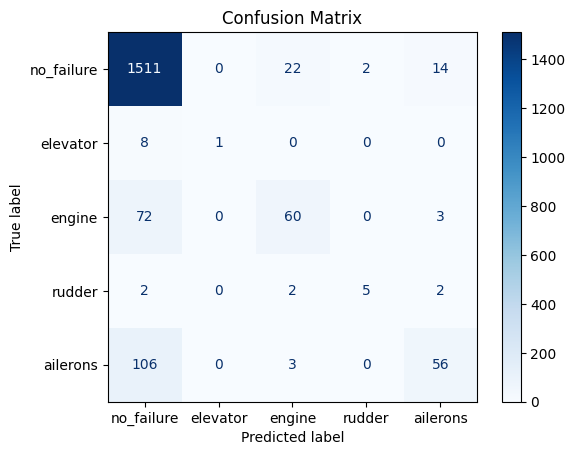

In [33]:
y_pred_knn = knn.predict(X_test)

knn_acc = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy della KNN: {knn_acc:.2f}")

report = classification_report(y_test, y_pred_knn, zero_division = 0.0, labels = class_labels)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()